In [2]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from shapely.geometry import Point, Polygon
import gmplot

from statsmodels.stats.weightstats import ttest_ind as ttest

from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Loading And Cleaning Data

In [3]:
path = ('/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/'+
        'sensing/gps/gps.zip')
zip_file = ZipFile(path)

# Creating dictionary with each file in the zip file loaded into a
# Pandas DataFrame as a value. Keys are the file names
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

# Adding a column to each dataframe that identifies the student id (each
# dataframe represents one student)
for df_key in dfs:
    df = dfs[df_key]
    df['uid'] = df_key

# Concatening all dataframes from dictionary
gps = pd.concat([dfs[df] for df in dfs],
                     sort=False)

In [48]:
gps_for_csv= gps[['uid', 'time', 'latitude', 'longitude']]
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/gps.csv'
gps_for_csv.to_csv(path, index=False)

There's what appears to be a missing comma at the end of the header of each CSV. The effect is that the column names are mismatched to the columns and the time variable is treated as the index. To solve this I reset the index and relabel the columns. Finally I use string methods to clean the uid (student id) column so that its just the integer and not the whole file name.

In [4]:
# Resetting index away from the unix time column
gps.reset_index(inplace=True)

# Renaming columns
gps.columns = ['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
       'altitude', 'bearing', 'speed', 'travelstate', 'drop_me', 'uid', 'drop_me_too']

# Making sure 'drop_me' and 'drop_me_too' have only empty values
print(gps.drop_me.unique(),
      gps.drop_me_too.unique())

# Dropping extraneous / empty columns
gps.drop(columns=['drop_me', 'drop_me_too'],
         inplace=True)

# Cleaning uid column unless it's already been cleaned
try:
    gps.uid = gps.uid.str.split('gps_u').str.get(1).str.split('.csv').str.get(0).astype(int)
except:
    print('gps.uid already cleaned.')
    
gps.head()

[nan] [nan]


time provider network_type  accuracy   latitude  longitude  \
0  1364410654  network         wifi    22.094  43.706605 -72.287042   
1  1364411866  network         wifi    24.652  43.706598 -72.287005   
2  1364852743  network         wifi    24.060  43.706614 -72.287039   
3  1364853942  network         wifi    25.242  43.706603 -72.287025   
4  1364854001      gps          NaN    14.000  43.707150 -72.286592   

     altitude  bearing     speed travelstate  uid  
0    0.000000      0.0  0.000000         NaN   45  
1    0.000000      0.0  0.000000         NaN   45  
2    0.000000      0.0  0.000000         NaN   45  
3    0.000000      0.0  0.000000         NaN   45  
4  199.399994      0.0  0.559017         NaN   45

# Scatterplotting Lat-Lon Data onto Campus Map

In [5]:
# This function creates a smaller dataframe within a square
# bounded area specified with Lat-Lon coordinates
def create_box_df(latlon_box, df):
    box_df = df.loc[
        (df.longitude > latlon_box[0]) &
        (df.longitude < latlon_box[1]) &
        (df.latitude > latlon_box[2]) &
        (df.latitude < latlon_box[3]), 
    :].copy()
    
    return box_df

Below we've created two lat-lon boxes that define two areas, the region around Vermont including major cities that includes most of the gps coordinates, and a smaller box containing all the points around campus and Hanover.

In [6]:
# For regional area around Vermont including New York, etc
regional_box =(
    -75,  # Left Lon
    -70,  # Right Lon
    40,   # Bottom Lat
    46    # Top Lat
)

# Area directly around campus and Hanover
hanover_box =(
    -72.2985,  # Left Lon
    -72.2810,  # Right Lon
    43.6990,   # Bottom Lat
    43.7100    # Top Lat
)

regional = create_box_df(regional_box, gps)
hanover = create_box_df(hanover_box, gps)

In [7]:
# Defining a function that plots all the coordinates
# from any given dataframe
def map_coordinates(box, image, df, dot_size, alpha):
    
    ratio = len(df) / len(gps)

    gps_map = plt.imread(image)

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           dpi=1000)
    sns.scatterplot(x=df.longitude,
                    y=df.latitude,
                    s=dot_size)
    ax.set_xlim(box[0],
                box[1])
    ax.set_ylim(box[2],
                box[3])
    ax.imshow(gps_map, zorder=0, extent = box, aspect= 'equal')
    plt.legend([])
    plt.title('{:.0%} of Coordinates'.format(ratio))
    plt.show()

First we'll take a look at the the dataframe as a whole, or just about all of it.

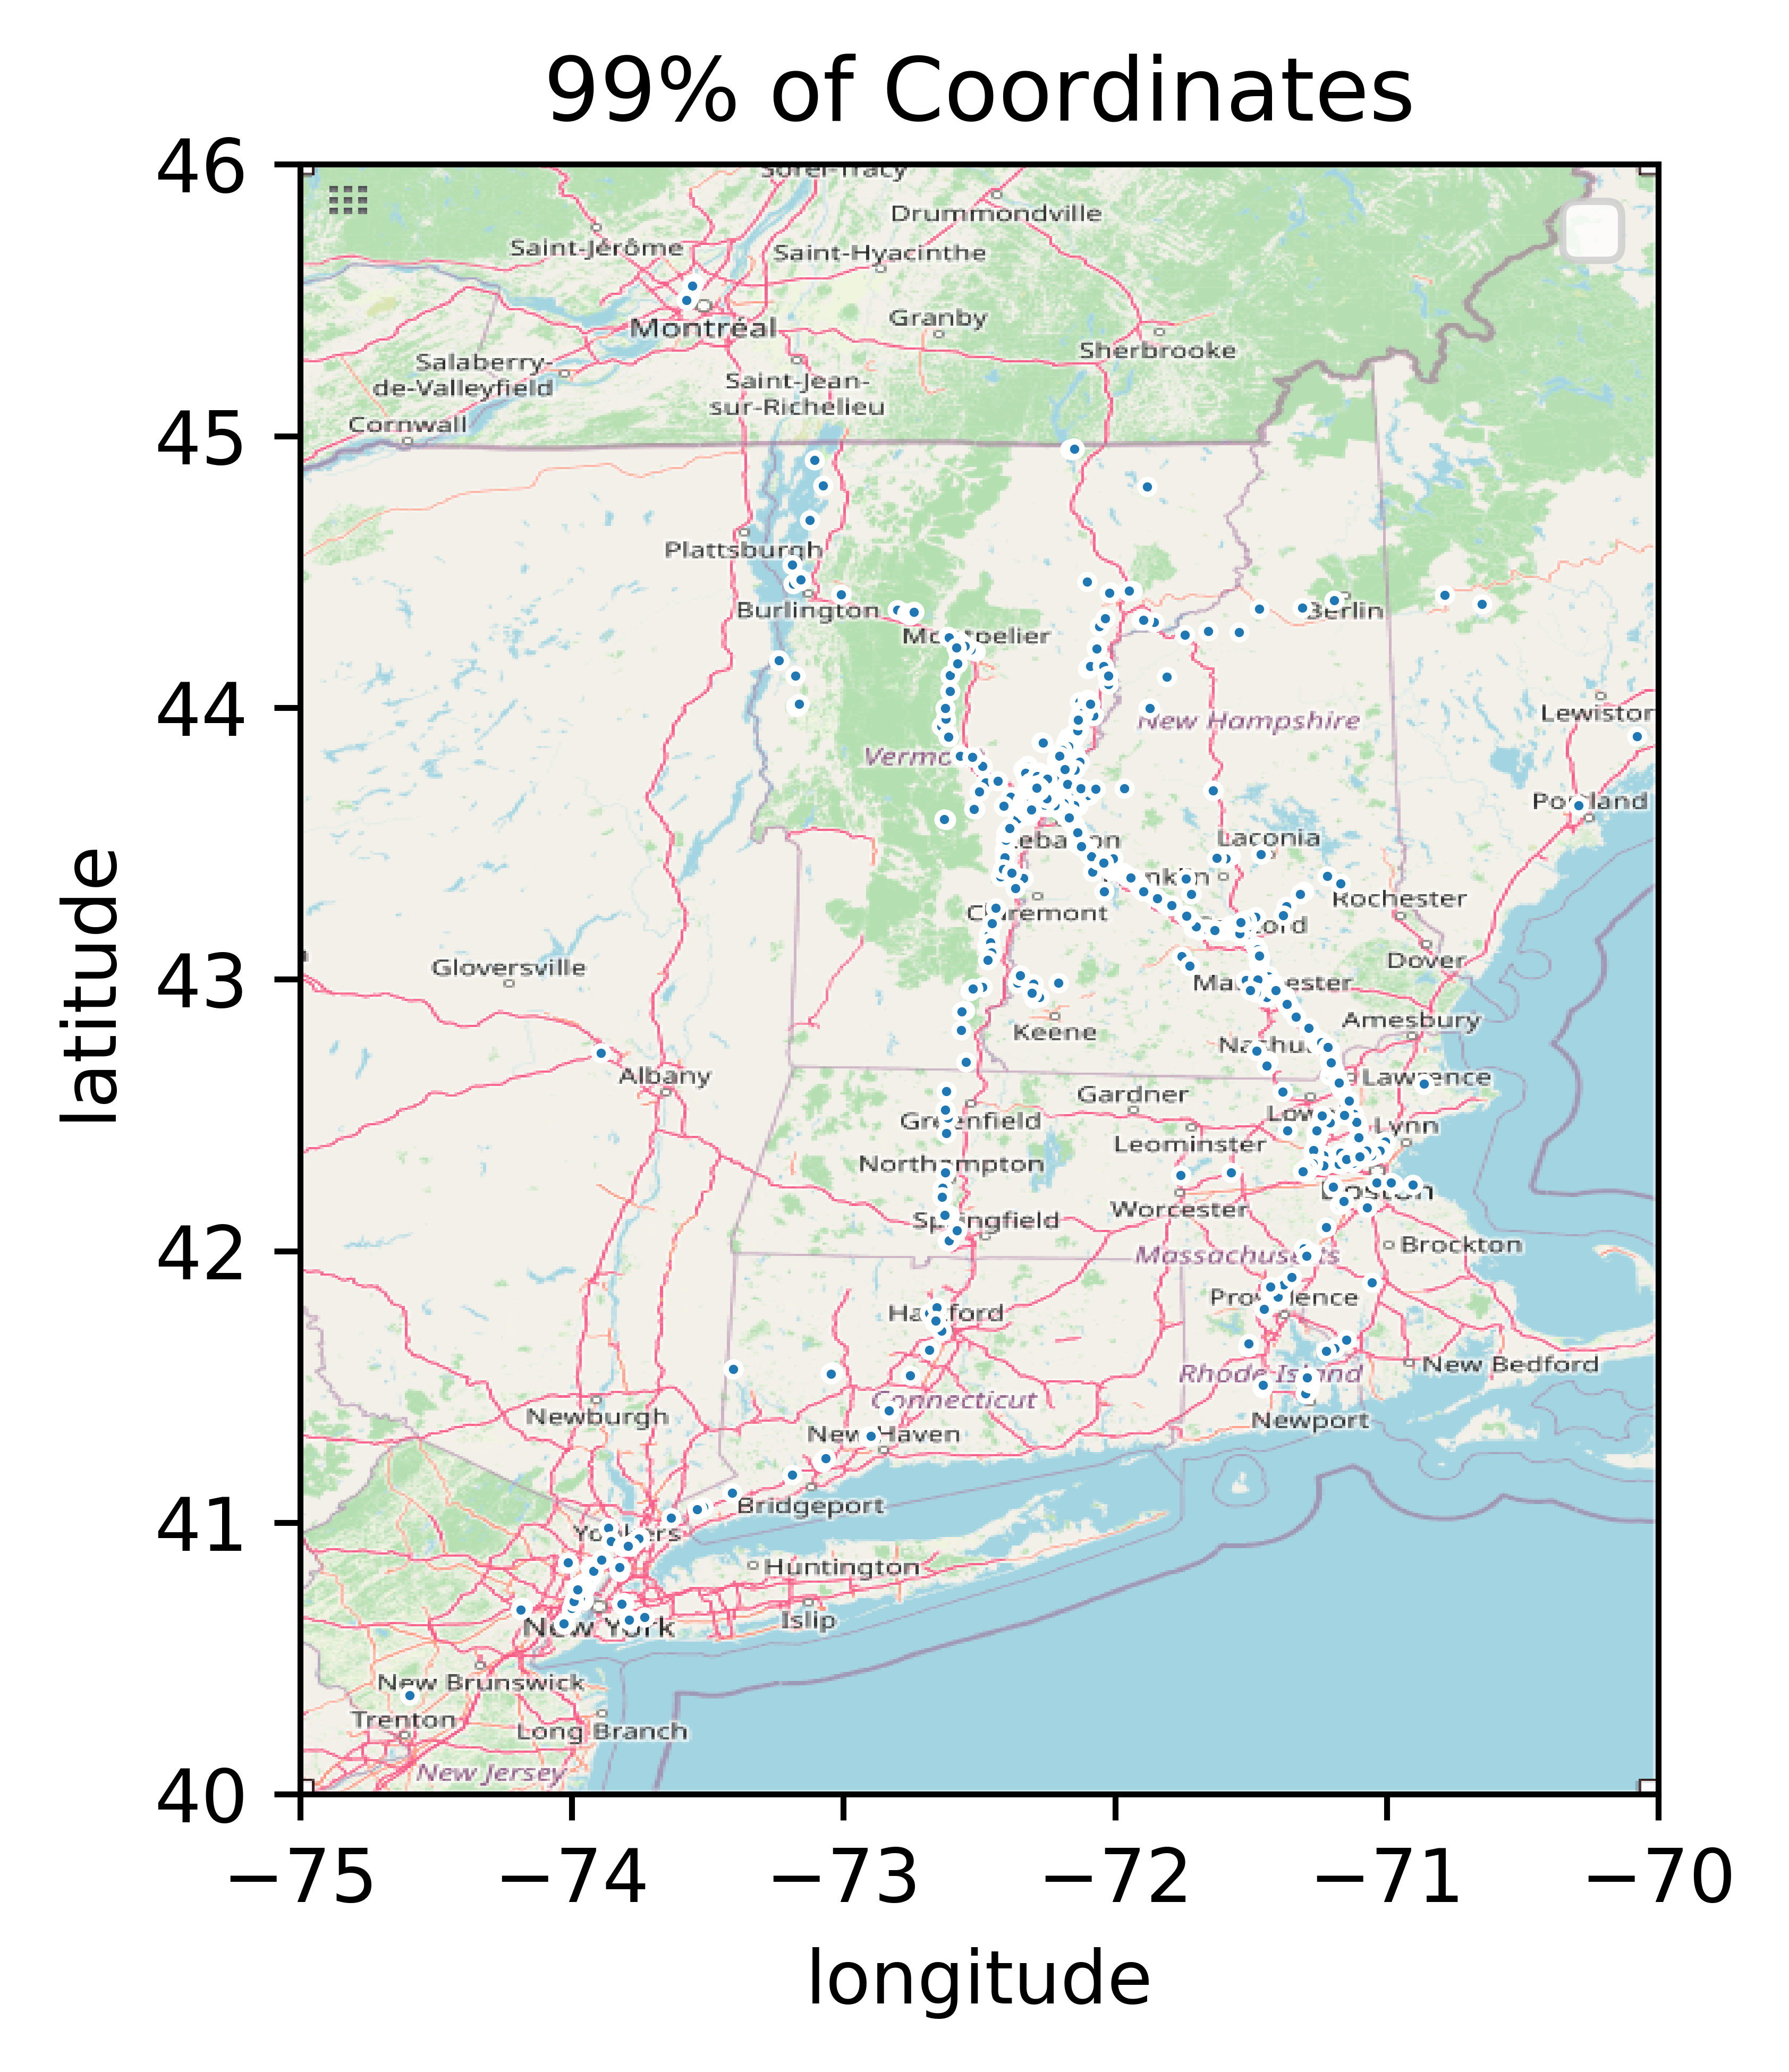

In [8]:
path = '/Users/kristiancanler/Desktop/regionalmap.png'

map_coordinates(
    regional_box,
    path,
    regional,
    4,
    .75)

About 17% of our coordinates lie outside of campus/hanover but within the region above. Here's a closer look at the spread of coordinates over the campus and hanover area. These are coordinates from all the students in the study, for all times of day, for any day in the 10 week period.

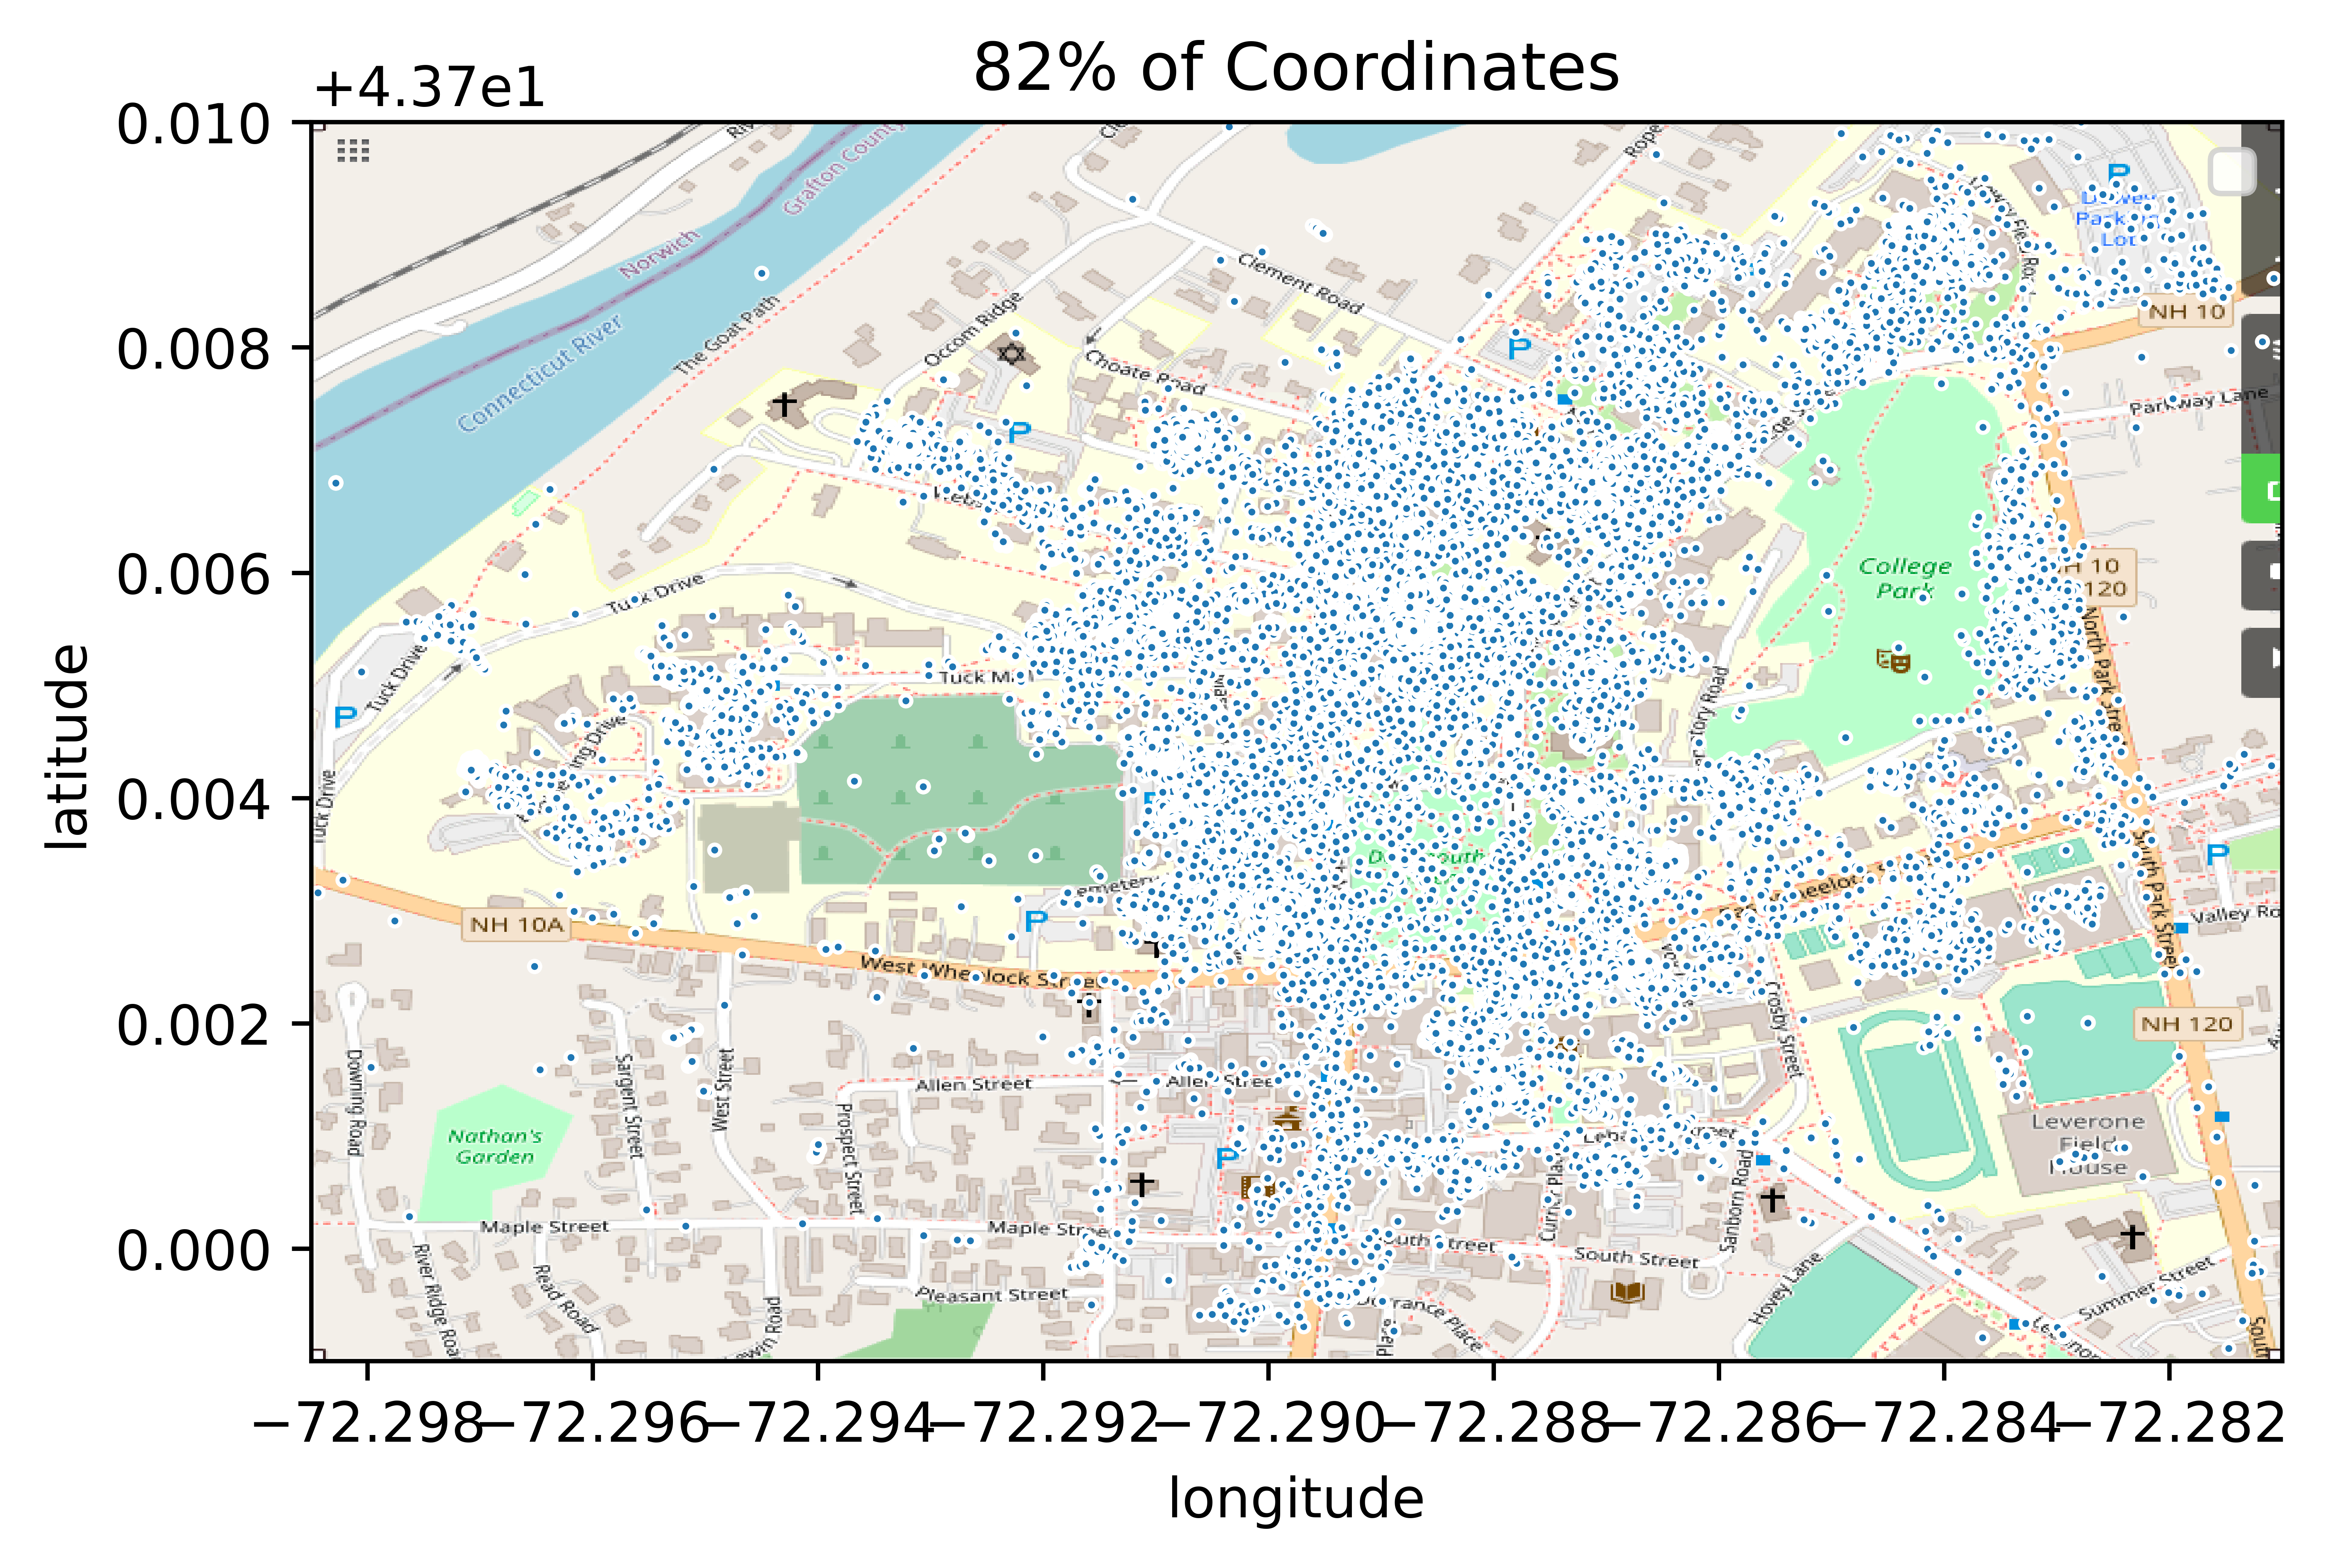

In [9]:
path = '/Users/kristiancanler/Desktop/openstreetmap2.png'

map_coordinates(
    hanover_box,
    path,
    hanover,
    4,
    .5
)

# Engineering & Visualizing New Time Features

The first thing we'll want to do is to get a feel for how this data changes over the course of the day. First we'll create a new feature representing datetime dervied from unix time, from which we can determine the hour of day any one of the given coordinates was registered.

Then we'll create four time brackets for the morning, the afternoon, the evening, nighttime, and then a late night / early morning period, from 3am to 6am, where we'l assume the majority of students are staying either in their residence or another place where they sometimes spend the night. We'll create a visualization giving a general look at the structure of that data, then zoom in on that last variable and create an unsupervised machine learning model to distinguish between the various residences. We'll then continue the same unsupervised analysis for daytime and evening to get a feel for how each student typically moves from place to place over the course of the average day.

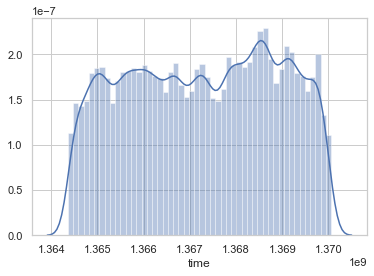

In [8]:
sns.set(style='whitegrid')
# Getting a look at the spread of gps time data
sns.distplot(gps.time)

In [9]:
# Creating datetime feature
gps['datetime'] = pd.to_datetime(gps.time, unit='s')

In [10]:
# Defining timeblocking periods with a dictionary
timeblock_dict = {
    'early morning': [3, 6],
    'morning': [6, 12],
    'afternoon': [12, 17],
    'evening': [17, 21],
    # night requires two entries to deal with 24/0h jump
    'night': [21, 24],
    'night': [0, 3]
}

for block in timeblock_dict:
    gps.loc[(gps['datetime'].dt.hour >= timeblock_dict[block][0]) &
            (gps['datetime'].dt.hour < timeblock_dict[block][1]),
            'timeblock'
           ] = block
    
# Regenerate regional and hanover dataframes with added columns
regional = create_box_df(regional_box, gps)
hanover = create_box_df(hanover_box, gps)

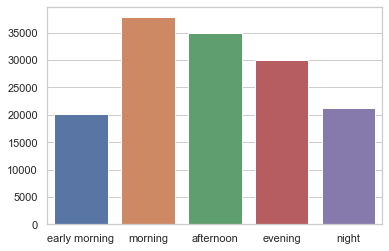

In [11]:
timeblocks = ['early morning', 'morning', 'afternoon', 'evening', 'night']

timeblock_counts = [len(hanover[hanover.timeblock==timeblock]) for timeblock in timeblocks]

sns.barplot(x=timeblocks,
            y=timeblock_counts)

In [12]:
def map_coordinates_with_hue(box, image_path, hue_var, title, df):
    ratio = len(df) / len(gps)

    gps_map = plt.imread(image_path)

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           dpi=1000)

    sns.scatterplot(x=df.longitude,
                    y=df.latitude,
                    hue=df[hue_var],
                    s=3,
                    alpha=.75,
                    markers='o')
    ax.set_xlim(box[0],
                box[1])
    ax.set_ylim(box[2],
                box[3])
    ax.imshow(gps_map, zorder=0, extent = box, aspect= 'equal')
    plt.legend()
    plt.title(title+'{:.0%} of Coordinates'.format(ratio))
    plt.show()

In [13]:
def compare_timeblocks(timeblock1, timeblock2):

    gps_map = plt.imread('/Users/kristiancanler/Desktop/openstreetmap2.png')
    
    timeblock1_df = hanover[hanover.timeblock == timeblock1]
    timeblock2_df = hanover[hanover.timeblock == timeblock2]

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           figsize=(15,8))
                            
    plt.subplot(121)
    ax1 = sns.scatterplot(x=timeblock1_df.longitude,
                            y=timeblock1_df.latitude,
                            s=5,
                            alpha=.75,
                            markers='o',
                            color='darkred')
    ax1.set_xlim(hanover_box[0],
                hanover_box[1])
    ax1.set_ylim(hanover_box[2],
                hanover_box[3])
    ax1.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.title(timeblock1+' {:.0%} of Coordinates'.format(len(timeblock1_df) / len(gps)))

    
    plt.subplot(122)
    ax2 = sns.scatterplot(x=timeblock2_df.longitude,
                    y=timeblock2_df.latitude,
                    s=5,
                    alpha=.75,
                    markers='o',
                    color='darkred')
    ax2.set_xlim(hanover_box[0],
                hanover_box[1])
    ax2.set_ylim(hanover_box[2],
                hanover_box[3])
    ax2.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.title(timeblock2+':  {:.0%} of Coordinates'.format(len(timeblock2_df) / len(gps)))
    plt.show()

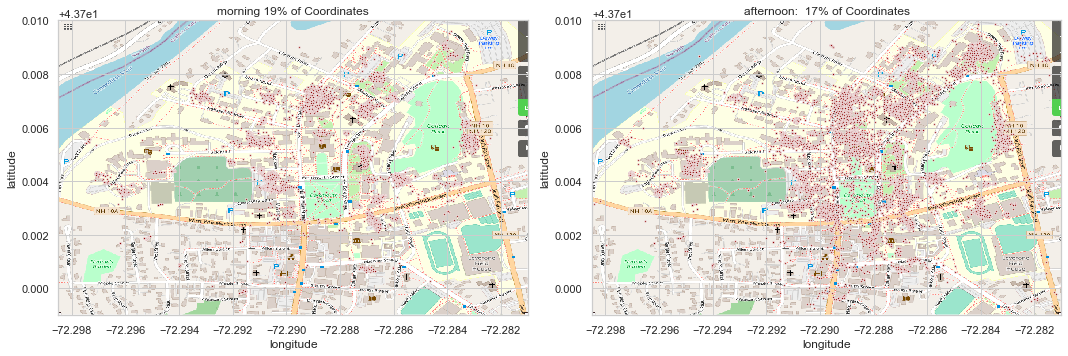

In [14]:
compare_timeblocks('morning', 'afternoon')

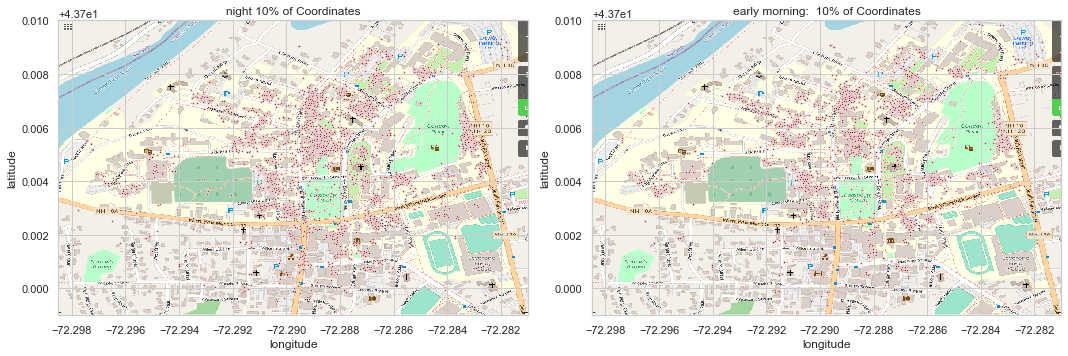

In [15]:
compare_timeblocks('night', 'early morning')

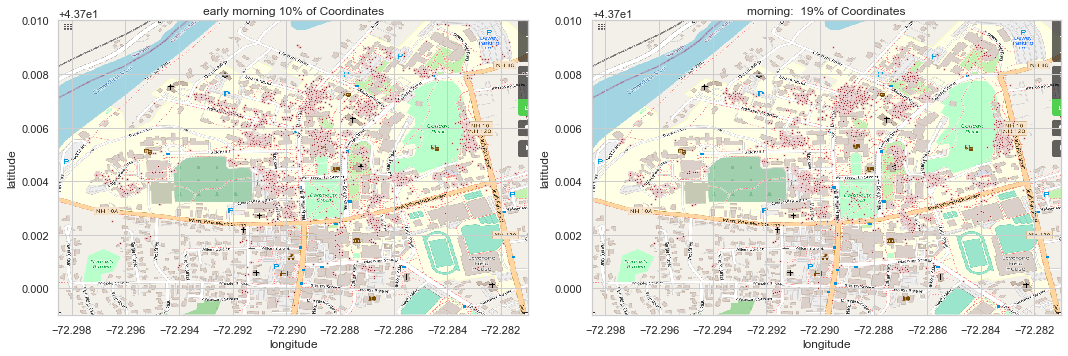

In [16]:
compare_timeblocks('early morning', 'morning')

# Clustering Overnight Coordinates

In [17]:
# Loading data for early morning sleeping hours into array 'X'
overnight = hanover.loc[hanover.timeblock=='early morning', :].copy()

# Removing lat-lon coordinates registered exactly at 3am to make current
# dataframe, clustering, and locations dictionary consistent with previous version
overnight = overnight[~(overnight.datetime.dt.hour==3)]

# Loading lat & lon values into 'X' array
X = overnight.loc[:, ['latitude', 'longitude']].copy()

Based on the research I've done so far, it looks like not standardizing Lat-Lon data is better for accurate clustering.

Here we're looking for the highest number of clusters that still gives us a maximal or close to maximal silhouette score. I've experimented with Heierarchical, DBSCAN, and K-Means, and K-means has performed the best by far.

In [18]:
def visualize_silhouette(k_vals, silhouette_scores):
    sns.set(style='whitegrid')
    lplot = sns.lineplot(k_vals, silhouette_scores, label='Silhouette score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Silhouette for K 10–35')
    lplot.set_xticks(k_vals)
    lplot.set_xticklabels(k_vals)
    plt.legend()
    plt.show()

In [19]:
# %%time
# k_vals = list(range(30, 60))
# silhouette_scores = []

# for k in k_vals:
#   kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
#   silhouette_score = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
#   silhouette_scores.append(silhouette_score)

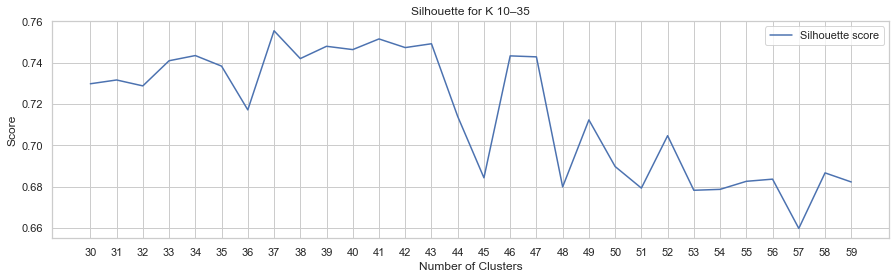

37 clusters performs slightly better than 47, but since we want to break down students into as precise locations as is possible, we'll take the largest number of clusters where the silhouette score doesn't significantly suffer.

In [20]:
%%time
# Loading K-Means labels into new feature in 'overnight' hanover dataframe subset
overnight.loc[:, 'kmeans'] = KMeans(n_clusters=47, random_state=42).fit_predict(X)

CPU times: user 2.24 s, sys: 244 ms, total: 2.49 s
Wall time: 1.36 s


In [21]:
# This function generates a map with all the lat-lon coordinates, but
# where each cluster has a different color
def map_clusters(df, num_clusters):

    gps_map = plt.imread('/Users/kristiancanler/Desktop/openstreetmap2.png')

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           dpi=1000)
    sns.scatterplot(x=df.longitude,
                    y=df.latitude,
                    hue=df.kmeans,
                    palette=sns.color_palette("hls", num_clusters),
                    s=3)
    ax.set_xlim(hanover_box[0],
                hanover_box[1])
    ax.set_ylim(hanover_box[2],
                hanover_box[3])
    ax.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.legend([])
    plt.show()

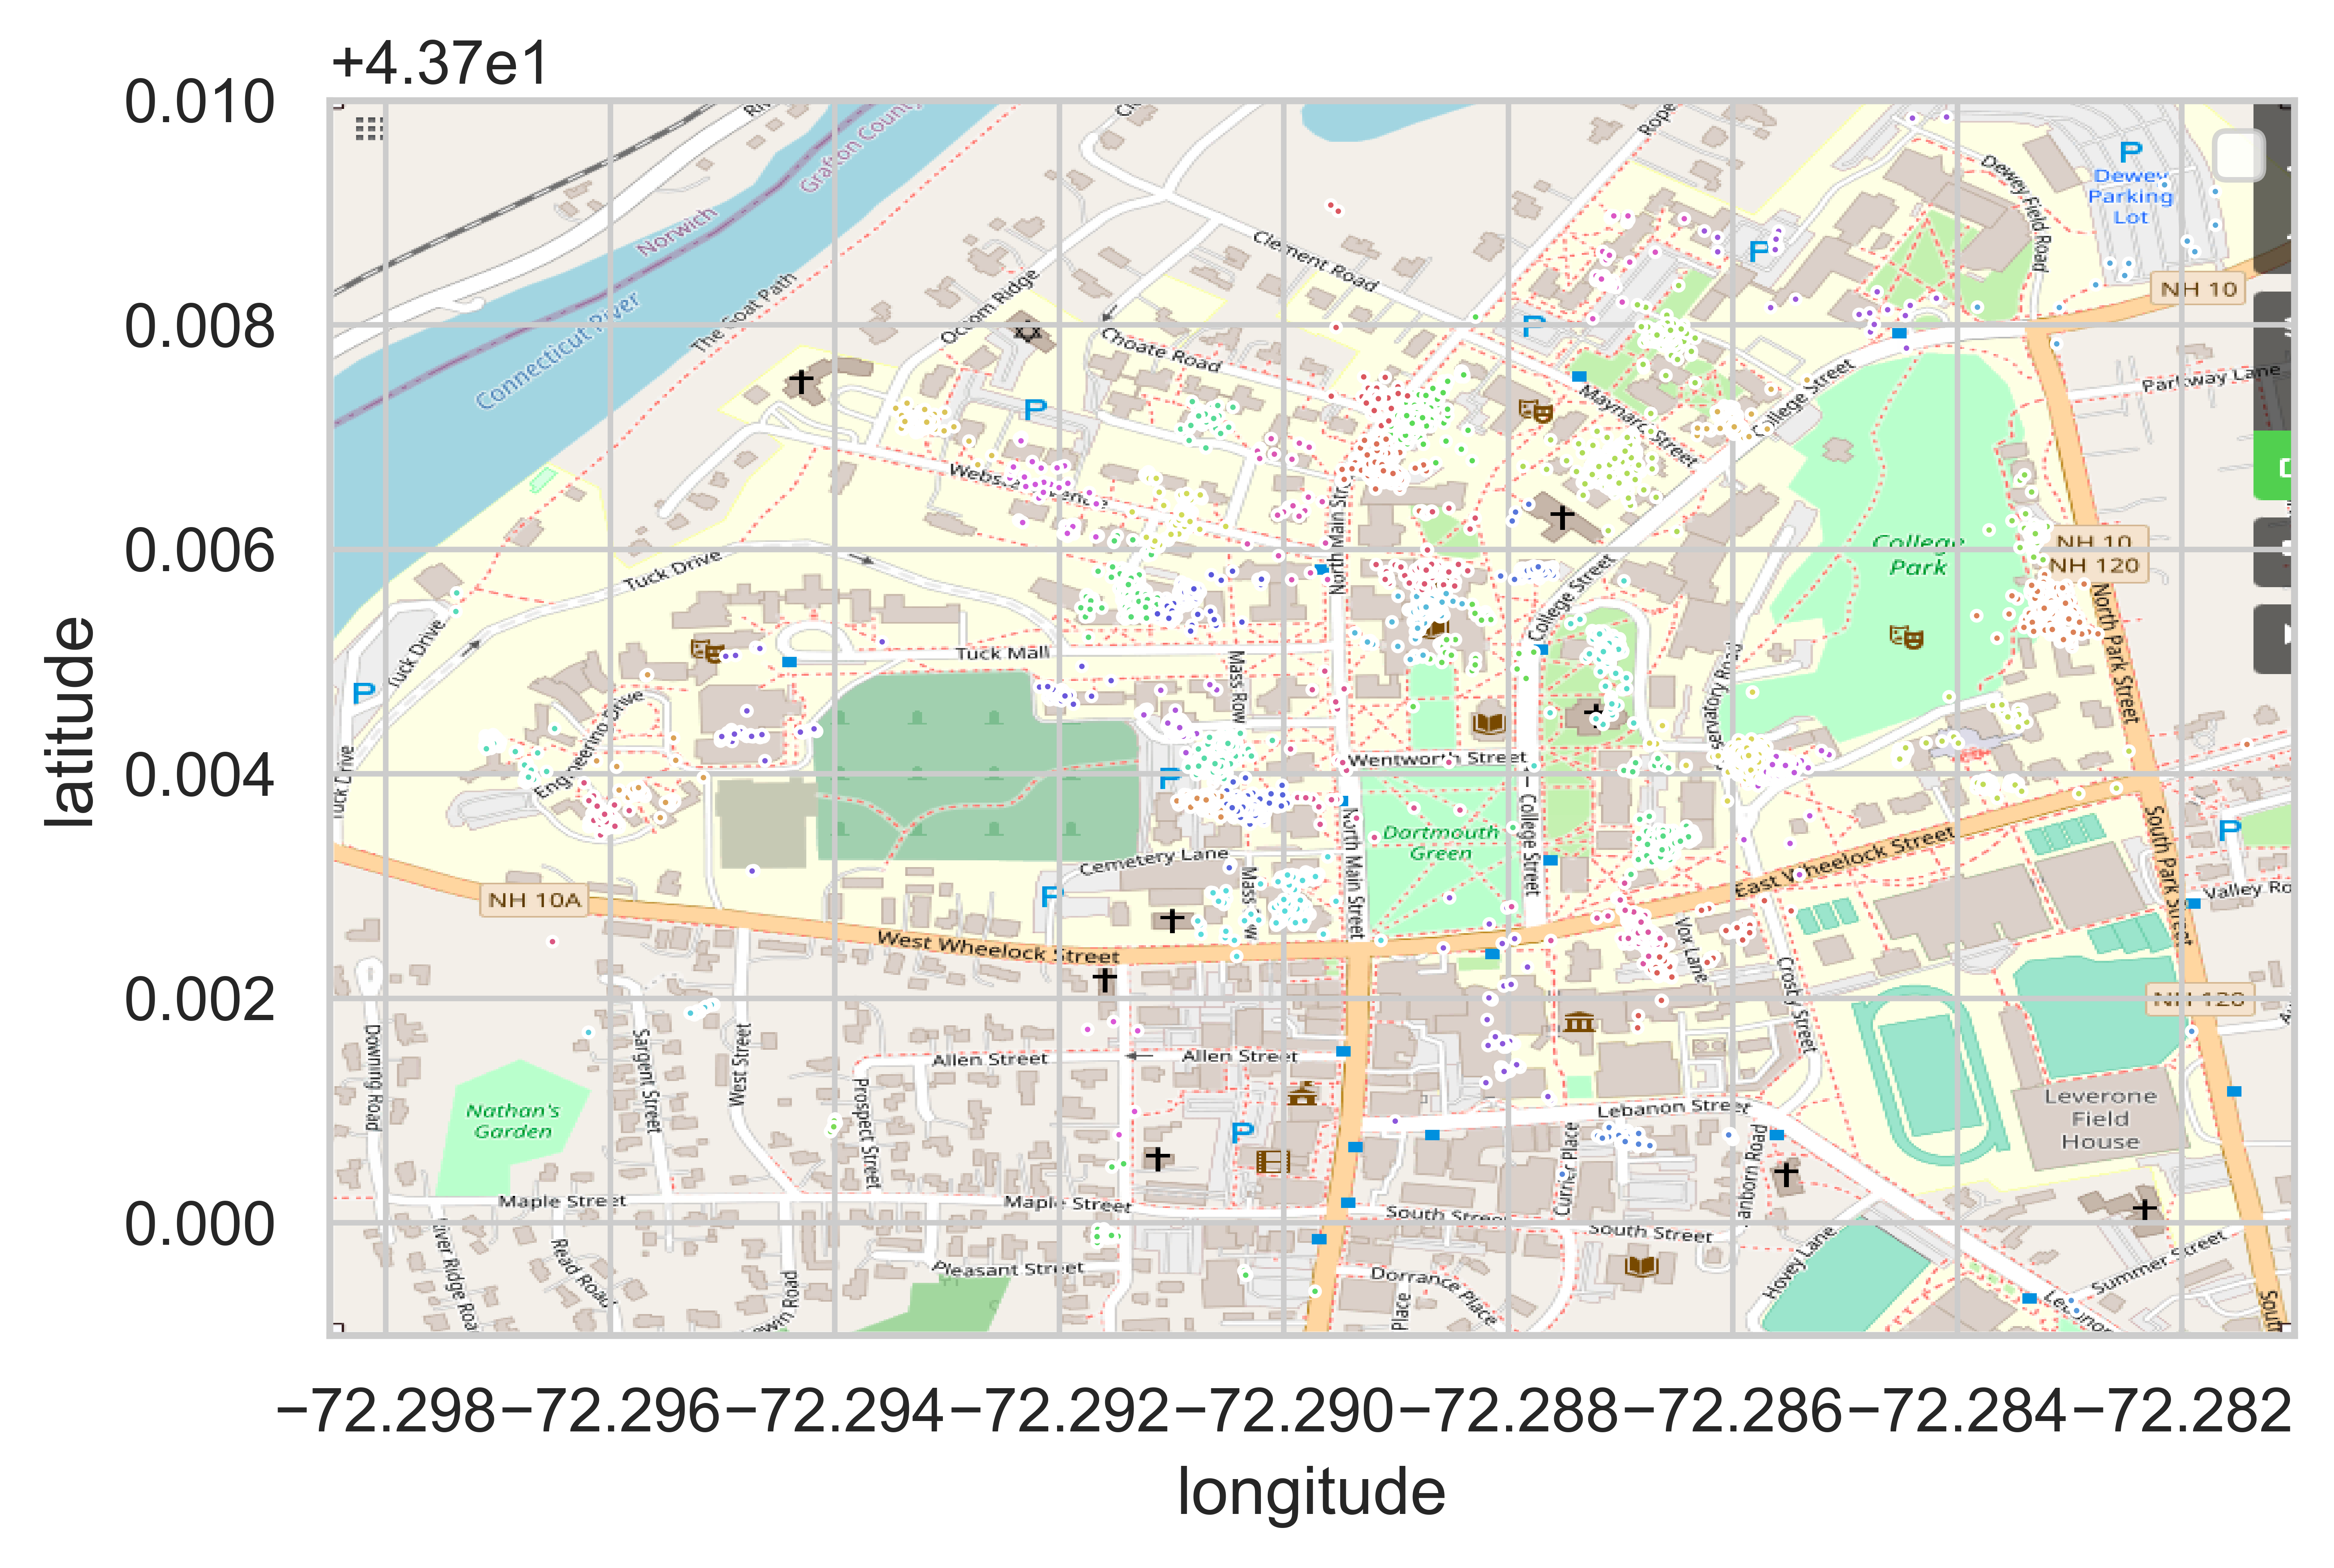

In [22]:
map_clusters(overnight, 47)

# Gathering Information about Overnight Clusters

I've returned to this cell from futher below to hard code splits into a small number of clusters that have fallen over buildings of different types (senior apartments and greek, say) that are very close together.

Cluster two is split across Triangle House and the North Park Apartments, which are also two different categories (living-learning and senior apartments). Cluster 15 is split across a greek house and the Native American House, which is a living-learning community.

The purpose of the cluster analysis here isn't to implement a model that's truly unsupervised, especially since we're running it simply to create a variable for a supervised model. Mainly, we're using it to save time and to also be able to group coordinates that are very close to a location, a dorm, say, but not technically inside.

In [23]:
overnight['kmeans_derived'] = overnight.loc[:,'kmeans']


overnight.loc[(overnight.kmeans_derived==2) &     # Splitting cluster 2 into two clsuters
          (overnight.latitude > 43.705247),
          'kmeans_derived'] = 47          # Creating cluster 47

overnight.loc[(overnight.kmeans_derived==15) &    # Splitting cluster 15 into two clusters
          (overnight.latitude > 43.707160),
          'kmeans_derived'] = 48          # Creating cluster 48

In [24]:
# Pulling Lat-Lon coordinate of the mean of each cluster
mean_latlon_dict = {}
for cluster in np.sort(overnight.kmeans.unique()): 
    lat_mean = stats.mean(overnight.loc[overnight.kmeans_derived==cluster, 'latitude'])
    lon_mean = stats.mean(overnight.loc[overnight.kmeans_derived==cluster, 'longitude'])
    
    mean_latlon_dict[cluster] = [lat_mean, lon_mean]

In [25]:
for cluster in list(range(10)):      # Use for loop to select which coordinates to print
    print(cluster, mean_latlon_dict[cluster])

0 [43.7023485383871, -72.2865166083871]
1 [43.706694447259416, -72.28910662062071]
2 [43.7051979655102, -72.28304255612245]
3 [43.70374971852697, -72.290718446722]
4 [43.703901063174605, -72.29572525857142]
5 [43.7071174985061, -72.28599257155489]
6 [43.707121862780845, -72.29322112040516]
7 [43.704161661660976, -72.28589798094426]
8 [43.706296537381974, -72.29093603321888]
9 [43.70397335033473, -72.2837424348954]


In the dictionary below, each cluster is paired with the name of the cluster's location, tracked by plugging the mean lat-lon coordinates into Google Maps. In some cases, these are particular buildings. In other cases, we've generalized slightly to include the house the building or hall is a part of, the department or school it's a part of, or if it's a part of a cluster of Greek buildings on Webster Ave.

The second string each cluster is paired with is the *type* of structure it is. This will most likely be the most rich information for our analysis.

In [26]:
locations_dict = {
    0: ['south_house', 'house'],
    1: ['phi_tau', 'greek'],
    2: ['triangle_house', 'living_learning'],
    3: ['school_house', 'house'],
    4: ['maxwell_hall', 'senior_apartments'],
    5: ['mclaughlin_cluster', 'living_learning'],
    6: ['epsilon_kappa_theta', 'greek'],
    7: ['north_park_house', 'house'],
    8: ['greek_webster_ave', 'greek'],
    9: ['east_wheelock_house', 'house'],
    10: ['computer_science_dept', 'academic'],
    11: ['mclaughlin_cluster', 'living_learning'],
    12: ['north_park_apartments', 'senior_apartments'],
    13: ['west_hanover', 'off_campus'],
    14: ['baker_library', 'library'],
    15: ['alpha_theta', 'greek'],
    16: ['south_hanover', 'off_campus'],
    17: ['west_house', 'house'],
    18: ['fayerweather_hall', 'firstyear'],
    19: ['choate_cluster', 'firstyear'],
    20: ['school_house', 'house'],
    21: ['french/judge_hall', 'firstyear'],
    22: ['wheeler_hall', 'firstyear'],
    23: ['collis_center', 'public'],
    24: ['west_hanover', 'off_campus'],
    25: ['berry_library', 'library'],
    26: ['dewey_parking_lot', 'off_campus'],
    27: ['east_hanover', 'off_campus'],
    28: ['the_lodge_south_house', 'house'],
    29: ['sigma_alpha_epsilon', 'house'],
    30: ['school_house', 'house'],
    31: ['west_house', 'house'],
    32: ['allen_house', 'house'],
    33: ['engineering_school', 'academic'],
    34: ['arts_center', 'academic'],
    35: ['medicine_school', 'academic'],
    36: ['house_center_b', 'house'],
    37: ['north_park_house', 'house'],
    38: ['greek_webster_ave', 'greek'],
    39: ['center_hanover', 'off_campus'],
    40: ['medicine_school', 'academic'],
    41: ['greek_webster_ave', 'greek'],
    42: ['south_house', 'house'],
    43: ['green', 'public'],
    44: ['channing_cox_hall', 'senior_apartments'],
    45: ['baker_library', 'library'],
    46: ['chinese_house', 'living_learning'],
    47: ['north_park_apartments', 'senior_apartments'],
    48: ['native_american_house', 'living_learning']
}

In [27]:
sns.set(style='whitegrid')
sizes = pd.DataFrame(
    {'cluster': [str(cluster) for cluster in overnight.kmeans_derived.unique()],
     'num': [len(overnight[overnight.kmeans_derived==cluster])
                 for cluster in overnight.kmeans_derived.unique()]
    })
sizes['relative'] = [ele / sizes.num.mean() - 1 for ele in sizes.num]
sizes.head(10)

cluster   num  relative
0      10  1408  4.206943
1      12   548  1.026566
2      34    55 -0.796604
3      26    13 -0.951925
4      35    53 -0.804000
5       5   328  0.212981
6      28    61 -0.774415
7      11   176 -0.349132
8      24    46 -0.829887
9      47  1443  4.336377

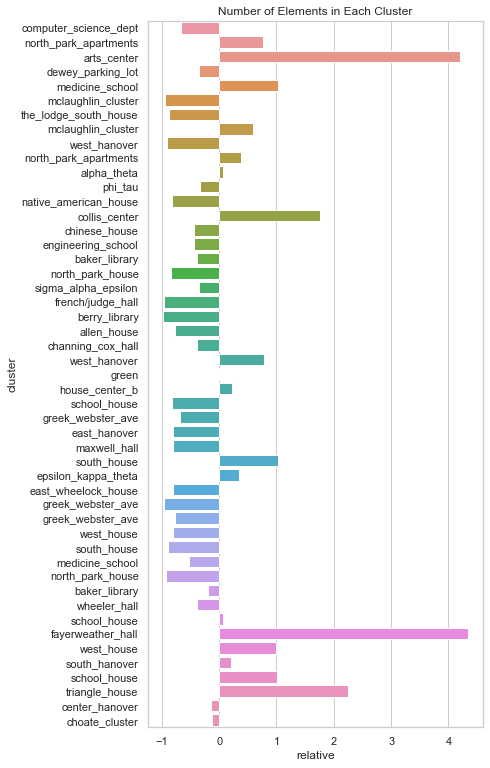

In [28]:
plt.figure(figsize=(6,13))

bplot = sns.barplot(
    x=sizes.relative,
    y=sizes.cluster,
    orient='h'
)
plt.title('Number of Elements in Each Cluster')
bplot.set_yticklabels([locations_dict[int(cluster)][0] for cluster in sizes.cluster])
plt.show()

In [29]:
# Generating cluster-wise dataframe with the cluster,
# equivalent overnight building, and the type of that building into df
locations_df = pd.DataFrame(
    {'cluster': list(locations_dict.keys()),
     'overnight_building': [lst[0] for lst in list(locations_dict.values())],
     'overnight_type': [lst[1] for lst in list(locations_dict.values())]
    })

# Adding equivalent columns to the overnight df (subset of hanover df, subset of gps df)
for cluster in locations_df.cluster:
    
    overnight.loc[overnight.kmeans_derived==cluster,
                  'overnight_building'
                 ] = locations_dict[cluster][0]
    
    overnight.loc[overnight.kmeans==cluster,
                  'overnight_type'
                 ] = locations_dict[cluster][1]

In [30]:
def group_size_temp_dfs(overnight):
    # Creating temporary df for type group sizes
    type_size = pd.DataFrame(
        {'type': locations_df.overnight_type.unique(),
         'num_ele': [len(overnight[overnight.overnight_type==type_])
                     for type_ in locations_df.overnight_type.unique()]
        }
    )

    type_size = type_size.sort_values(by='num_ele',
                                        ascending=False)

    # Creating temporary df for building group sizes
    building_size = pd.DataFrame(
        {'type': locations_df.overnight_building.unique(),
         'num_ele': [len(overnight[overnight.overnight_building==building])
                     for building in locations_df.overnight_building.unique()]
        }
    )

    building_size = building_size.sort_values(by='num_ele',
                                              ascending=False)
    
    return type_size, building_size

type_size, building_size = group_size_temp_dfs(overnight)

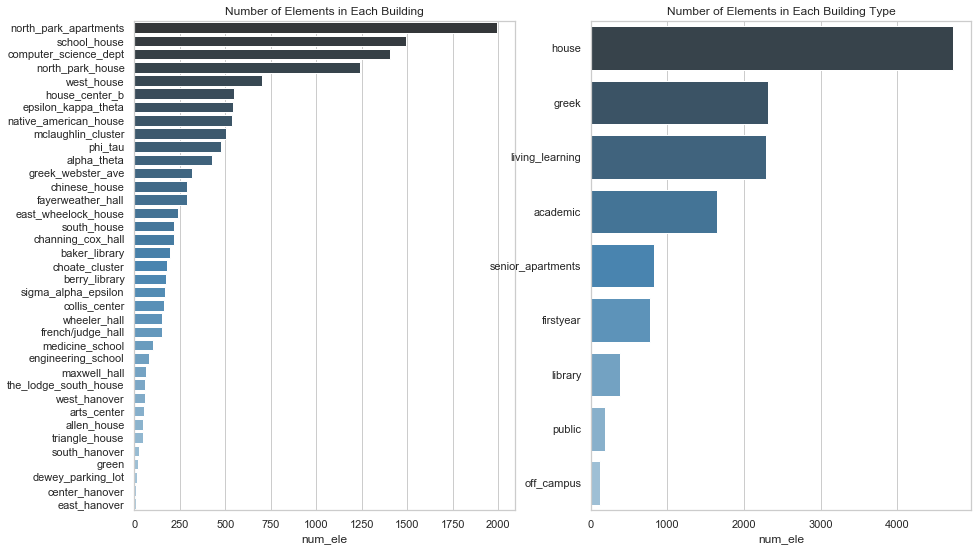

In [31]:
# Visualizing group sizes
plt.figure(figsize=(15,9))

plt.subplot(121)
pal = sns.color_palette("Blues_d", len(building_size.num_ele))
rank = building_size.num_ele.argsort().argsort()
sns.barplot(
    x=building_size.num_ele,
    y=building_size.type,
    orient='h',
    palette=np.array(pal[::-1])[rank])
plt.ylabel('')
plt.title('Number of Elements in Each Building')

plt.subplot(122)
pal = sns.color_palette("Blues_d", len(type_size.num_ele))
rank = type_size.num_ele.argsort().argsort()
sns.barplot(x=type_size.num_ele,
            y=type_size.type,
            orient='h',
            palette=np.array(pal[::-1])[rank])
plt.title('Number of Elements in Each Building Type')
plt.ylabel('')
plt.show()

# Gathering Information about Daytime Clusters

In [32]:
hanover.timeblock.unique()

array(['evening', nan, 'afternoon', 'night', 'early morning', 'morning'],
      dtype=object)

In [33]:
# Loading data for early morning sleeping hours into array 'X'
daytime = hanover.loc[
    ((hanover.timeblock=='morning') |
    (hanover.timeblock=='afternoon')),
    :].copy()

# Removing lat-lon coordinates registered exactly at 7am to make current
# dataframe, clustering, and locations dictionary consistent with previous version
daytime = daytime[~(daytime.datetime.dt.hour==7)]

# Loading lat & lon values into 'X' array
X_day = daytime.loc[:, ['latitude', 'longitude']].copy()

#### Concatenating Kmeans dataframe

In [52]:
overnight.columns

Index(['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
       'altitude', 'bearing', 'speed', 'travelstate', 'uid', 'datetime',
       'timeblock', 'kmeans', 'kmeans_derived', 'overnight_building',
       'overnight_type'],
      dtype='object')

In [53]:
daytime.columns

Index(['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
       'altitude', 'bearing', 'speed', 'travelstate', 'uid', 'datetime',
       'timeblock', 'kmeans', 'kmeans_derived'],
      dtype='object')

In [59]:
latlon_kmeans = pd.concat([overnight.drop(columns=['overnight_building']),
                           daytime],
                          axis=0,
                          sort=False)
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon_kmeans.csv'
latlon_kmeans.to_csv(path, index=False)

In [ ]:
# %%time
# # Trying some values for k between 20 & 50
# k_vals = list(range(20,50,3))
# silhouette_scores = []

# for k in k_vals:
#   kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X_day)
#   silhouette_score = metrics.silhouette_score(X_day, kmeanslabels, metric='euclidean')
#   silhouette_scores.append(silhouette_score)

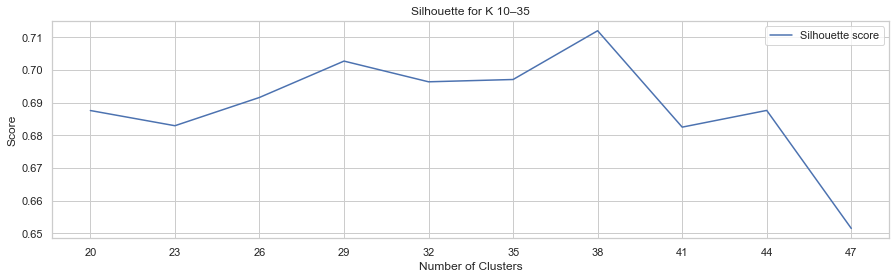

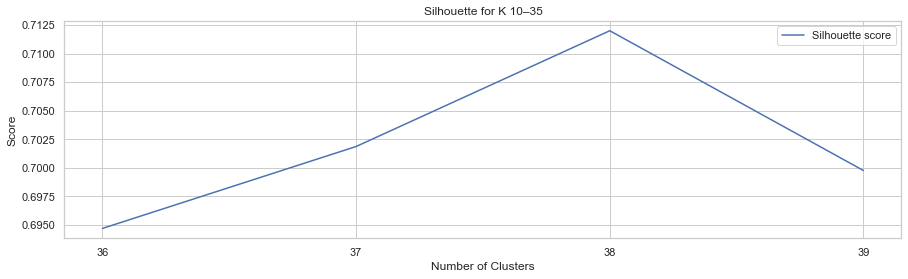

In [34]:
%%time
daytime['kmeans'] = KMeans(n_clusters=36, random_state=42).fit_predict(X_day)

CPU times: user 7.37 s, sys: 1.28 s, total: 8.65 s
Wall time: 5.02 s


In [35]:
daytime['kmeans_derived'] = daytime.loc[:,'kmeans'].copy()

daytime.loc[(daytime.kmeans_derived==2) &
            (daytime.latitude > 43.705247),
           'kmeans_derived'] = 36

daytime.loc[(daytime.kmeans_derived==9) &
          (daytime.latitude > 43.707160),
          'kmeans_derived'] = 37

daytime.loc[(daytime.kmeans_derived==16) &
          (daytime.latitude > 43.704651),
          'kmeans_derived'] = 38

daytime.loc[(daytime.kmeans_derived==28) &
          (daytime.latitude > 43.706696),
          'kmeans_derived'] = 39

In [36]:
# Pulling Lat-Lon coordinate of the mean of each cluster
mean_latlon_dict = {}
for cluster in np.sort(daytime.kmeans_derived.unique()): 
    lat_mean = stats.mean(daytime.loc[daytime.kmeans_derived==cluster, 'latitude'])
    lon_mean = stats.mean(daytime.loc[daytime.kmeans_derived==cluster, 'longitude'])
    
    mean_latlon_dict[cluster] = [lat_mean, lon_mean]

In [37]:
daytime_locations_dict = {
    0: ['school_house', 'house'],
    1: ['computer_science_dept', 'academic'],
    2: ['triangle_house', 'living_learning'],
    3: ['south_house', 'house'],
    4: ['engineering_school', 'academic'],
    5: ['medicine_school', 'academic'],
    6: ['west_house', 'house'],
    7: ['berry_library', 'public'],
    8: ['greek_webster_ave', 'greek'],
    9: ['alpha_theta', 'greek'],
    10: ['east_wheelock_house', 'house'],
    11: ['channing_cox_hall', 'senior_apartments'],
    12: ['north_park_house', 'house'],
    13: ['main_st_hanover', 'off_campus'],
    14: ['mclaughlin_cluster', 'living_learning'],
    15: ['south_house', 'house'],
    16: ['french/judge_hall', 'firstyear'],
    17: ['collis_center', 'public'],
    18: ['humanities_depts', 'academic'],
    19: ['north_park_apartments', 'senior_apartments'],
    20: ['choate_cluster', 'firstyear'],
    21: ['allen_house', 'house'],
    22: ['wheeler_hall', 'firstyear'],
    23: ['west_hanover', 'off_campus'],
    24: ['mclaughlin_cluster', 'living_learning'],
    25: ['gym', 'athletic'],
    26: ['fayerweather_hall', 'firstyear'],
    27: ['right_hanover', 'off_campus'],
    28: ['math_and_humanities', 'academic'],
    29: ['53_commons', 'public'],
    30: ['green', 'public'],
    31: ['arts_center', 'academic'],
    32: ['medicine_school', 'academic'],
    33: ['school_house', 'house'],
    34: ['life_sciences_dept', 'academic'],
    35: ['greek_webster_ave', 'greek'],
    36: ['north_park_apartments', 'senior_apartments'],
    37: ['native_american_house', 'living_learning'],
    38: ['boat_house', 'athletic'],
    39: ['phi_tau', 'greek']
}

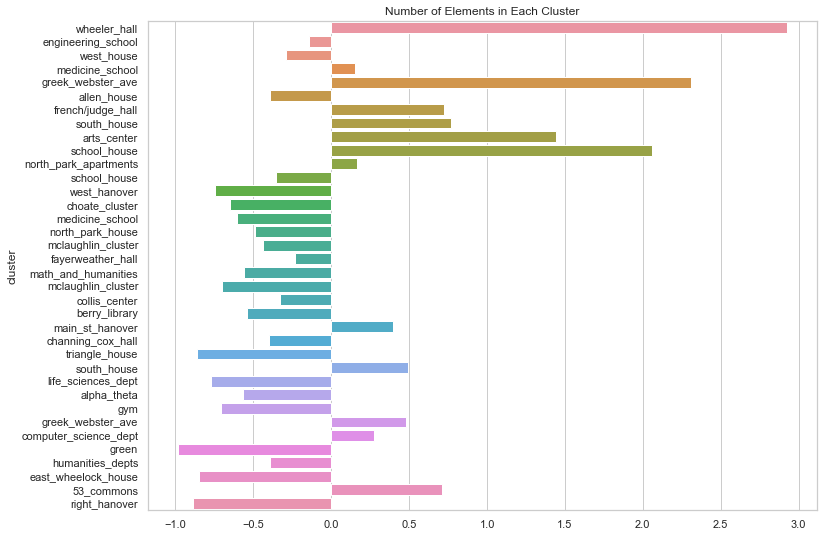

In [38]:
cluster_size = pd.DataFrame(
    {'cluster': daytime.kmeans.unique(),
     'num_ele': [len(daytime[daytime.kmeans==cluster])
                 for cluster in daytime.kmeans.unique()]
    }
)
    
plt.figure(figsize=(12,9))
bplot = sns.barplot(
    x=[ele/cluster_size.num_ele.mean()-1 for ele in cluster_size.num_ele],
    y=cluster_size.cluster,
    orient='h')
plt.title('Number of Elements in Each Cluster')
bplot.set_yticklabels([daytime_locations_dict[int(cluster)][0] for cluster in cluster_size.cluster])
plt.show()

# Cluster of Lat-Lon Data for All Times of Day

In [39]:
# Loading lat & lon values into 'X' array
X_allday = hanover.loc[:, ['latitude', 'longitude']].copy()

In [512]:
# %%time
# # Trying some values for k between 20 & 50
# k_vals = list(range(20,50,4))
# silhouette_scores = []

# for k in k_vals:
#   kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X_allday)
#   silhouettescore = metrics.silhouette_score(X_allday, kmeanslabels, metric='euclidean')
#   silhouette_scores.append(silhouettescore)

In [513]:
# visualize_silhouette(k_vals, silhouette_scores)

# Creating Student-wise locations df

In [40]:
latlon_df = pd.DataFrame()
latlon_df['uid'] = gps.uid.unique()

In [41]:
for uid in latlon_df.uid:
    
    clusters = overnight[overnight.uid==uid, 'kmeans_derived']

TypeError: '(887        True
888        True
889        True
890        True
891        True
          ...  
202710    False
202711    False
202712    False
202713    False
202714    False
Name: uid, Length: 13250, dtype: bool, 'kmeans_derived')' is an invalid key

In [42]:
for uid in overnight.uid.unique():
    overnight_1 = (overnight.loc[overnight.uid==uid,
                                 'kmeans_derived']
                   .value_counts(ascending=False)
                   .reset_index()
                  .iloc[0,0])
    
    try:
        overnight_2 = (overnight.loc[overnight.uid==uid,
                                     'kmeans_derived']
                       .value_counts(ascending=False)
                       .reset_index()
                       .iloc[1,0])
    except:
        overnight2=np.nan
    
    daytime_1 = (
        daytime.loc[daytime.uid==uid,
                    'kmeans_derived']
        .value_counts(ascending=False)
        .reset_index()
        .iloc[0,0])
    
    daytime_2 = (
        daytime.loc[daytime.uid==uid,
                    'kmeans_derived']
        .value_counts(ascending=False)
        .reset_index()
        .iloc[1,0])
    
    daytime_3 = (
        daytime.loc[daytime.uid==uid,
                    'kmeans_derived']
        .value_counts(ascending=False)
        .reset_index()
        .iloc[2,0])
        
    latlon_df.loc[latlon_df.uid==uid, 'overnight_primary_cluster'] = overnight_1
    latlon_df.loc[latlon_df.uid==uid, 'overnight_primary_bld'] = locations_dict[int(overnight_1)][0]
    latlon_df.loc[latlon_df.uid==uid, 'overnight_primary_type'] = locations_dict[int(overnight_1)][1]
    
    latlon_df.loc[latlon_df.uid==uid, 'overnight_secondary_cluster'] = overnight_2
    latlon_df.loc[latlon_df.uid==uid, 'overnight_secondary_bld'] = locations_dict[int(overnight_2)][0]
    latlon_df.loc[latlon_df.uid==uid, 'overnight_secondary_type'] = locations_dict[int(overnight_2)][1]
    
    latlon_df.loc[latlon_df.uid==uid, 'daytime_primary_cluster'] = daytime_1
    latlon_df.loc[latlon_df.uid==uid, 'daytime_primary_bld'] = locations_dict[int(daytime_1)][0]
    latlon_df.loc[latlon_df.uid==uid, 'daytime_primary_type'] = locations_dict[int(daytime_1)][1]
    
    latlon_df.loc[latlon_df.uid==uid, 'daytime_secondary_cluster'] = daytime_2
    latlon_df.loc[latlon_df.uid==uid, 'daytime_secondary_bld'] = locations_dict[int(daytime_2)][0]
    latlon_df.loc[latlon_df.uid==uid, 'daytime_secondary_type'] = locations_dict[int(daytime_2)][1]
    
    latlon_df.loc[latlon_df.uid==uid, 'daytime_tertiary_cluster'] = daytime_3
    latlon_df.loc[latlon_df.uid==uid, 'daytime_tertiary_bld'] = locations_dict[int(daytime_3)][0]
    latlon_df.loc[latlon_df.uid==uid, 'daytime_tertiary_type'] = locations_dict[int(daytime_3)][1]

In [520]:
latlon_df.to_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon.csv', index=False)

ValueError: Cannot display a file using FileLinks. Use FileLink to display '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon.csv'.

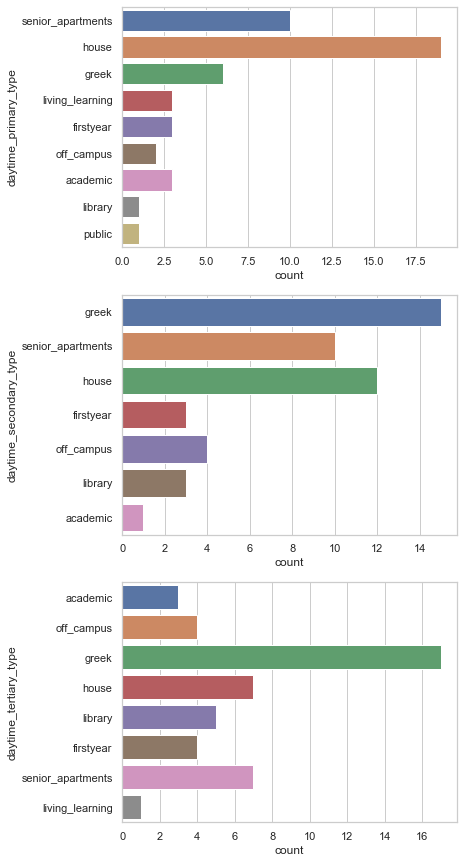

In [501]:
plt.figure(figsize=(6,15))
plt.subplot(311)
sns.countplot(y=latlon_df.daytime_primary_type)
plt.subplot(312)
sns.countplot(y=latlon_df.daytime_secondary_type)
plt.subplot(313)
sns.countplot(y=latlon_df.daytime_tertiary_type)